In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 590034, done.
remote: Counting objects: 100% (37820/37820), done.
remote: Compressing objects: 100% (2382/2382), done.
remote: Total 590034 (delta 35379), reused 37531 (delta 35166), pack-reused 552214 (from 1)
Receiving objects: 100% (590034/590034), 1.10 GiB | 20.64 MiB/s, done.
Resolving deltas: 100% (551468/551468), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import os
import shutil
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass
import json

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
from torchvision import datasets, transforms
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import utils
from engine import train_one_epoch, evaluate
from tqdm import tqdm
import shutil


In [ ]:
# Make sure the destination directory exists
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move the file
shutil.move('kaggle.json', '/root/.config/kaggle/kaggle.json')

'/root/.config/kaggle/kaggle.json'

In [ ]:
!kaggle datasets download sshikamaru/udacity-self-driving-car-dataset

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/udacity-self-driving-car-dataset
License(s): other
100% 1.07G/1.07G [00:55<00:00, 25.4MB/s]
100% 1.07G/1.07G [00:55<00:00, 20.9MB/s]


In [ ]:
import zipfile

file_path = '/content/udacity-self-driving-car-dataset.zip'
extract_to = '/content/'

try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("The file is corrupted or not a valid ZIP file.")


Extraction successful!


In [ ]:
!rm udacity-self-driving-car-dataset.zip

**Technique #1: Object Detection using Faster RCNN**

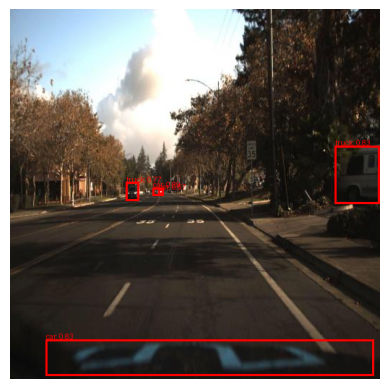

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# COCO class labels (80 classes)
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Load a pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define a transform to normalize the image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Function to perform object detection on an image
def detect_objects(image_path):
    # Open image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        prediction = model(image_tensor)

    return prediction, image

# Function to draw bounding boxes on the image and label the detected objects
def draw_boxes(image, prediction, score_threshold=0.5):
    draw = ImageDraw.Draw(image)
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label = prediction[0]['labels'][element].cpu().numpy()

        if score > score_threshold:
            # Draw the bounding box
            draw.rectangle(box, outline="red", width=3)

            # Get the label from COCO_CLASSES
            label_text = COCO_CLASSES[label]

            # Draw the label and score
            label_position = (box[0], box[1] - 10)  # Position label above the box
            draw.text(label_position, f"{label_text}: {score:.2f}", fill="red")

    return image

# Load the image and run detection
image_path = '/content/data/export/1478019955679801306_jpg.rf.e0c1afab5b4a00d9812e56907cd1b9bf.jpg'  # Replace with your image path
prediction, image = detect_objects(image_path)

# Draw bounding boxes and labels on the image
image_with_boxes = draw_boxes(image, prediction)

# Display the result
plt.imshow(image_with_boxes)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
import zipfile
import os

# Step 1: Zip the folder on your local computer before uploading.
# This step is done locally. On most systems, right-click the folder and select "Compress" or "Zip."

# Step 2: Upload the zipped folder
# uploaded = files.upload()  # This will prompt you to upload a file (the zipped folder)

# Step 3: Extract the contents of the zipped folder
for filename in ['/content/aug_images.zip', '/content/json.zip']:
    zip_path = filename  # Use the uploaded file name
    folder_name = os.path.splitext(filename)[0]  # Extract the folder name without the .zip extension

    # Create the folder if it doesn't exist
    os.makedirs(folder_name, exist_ok=True)

    # Extract the zip file into the folder
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)

print(f"Folder extracted to: {folder_name}")


Folder extracted to: /content/json


In [ ]:
import os
import json
import torch

# Function to convert a single JSON file into the desired format
def convert_json_to_pytorch_format(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    label_encodings = {
        "Solid White Road Line": 0,
        "Dotted White Road Line": 1,
        "Double Solid Yellow Road Line": 2
    }

    annotations = []

    for shape in data['shapes']:
        label = shape['label']
        if label not in label_encodings:
            label_encodings[label] = len(label_encodings)
        label_idx = label_encodings[label]
        points = shape['points']

        # Calculate bounding box from polygon points
        min_x = min(point[0] for point in points)
        max_x = max(point[0] for point in points)
        min_y = min(point[1] for point in points)
        max_y = max(point[1] for point in points)

        # Only add bounding boxes that are valid
        if min_x < max_x and min_y < max_y:
            annotations.append({
                'label': label_idx,
                'points': [min_x, min_y, max_x, max_y]
            })

    return annotations  # Return only valid annotations

# Function to process all JSON files in a folder
def process_folder(folder_path):
    # Create a folder to save converted files (if not exists)
    output_folder = os.path.join(folder_path, "converted")
    os.makedirs(output_folder, exist_ok=True)

    # Process each JSON file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            json_file = os.path.join(folder_path, filename)
            print(f"Processing {json_file}...")

            annotations = convert_json_to_pytorch_format(json_file)

            # Skip saving files with no valid annotations
            if not annotations:
                print(f"No valid bounding boxes for {filename}. Skipping.")
                continue

            # Save the annotations as a separate JSON file
            output_annotation_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.json")
            with open(output_annotation_path, 'w') as f:
                json.dump(annotations, f, indent=4)

            print(f"Saved converted data for {filename}")

# Specify the folder containing the JSON files
folder_path = "/content/json/json"
process_folder(folder_path)


Processing /content/json/json/1478019957687018435_jpg_aug_1.json...
Saved converted data for 1478019957687018435_jpg_aug_1.json
Processing /content/json/json/1478020363696079371_jpg_aug_1.json...
Saved converted data for 1478020363696079371_jpg_aug_1.json
Processing /content/json/json/1478019958682197101_jpg_original.json...
Saved converted data for 1478019958682197101_jpg_original.json
Processing /content/json/json/1478019952686311006_jpg_aug_2.json...
Saved converted data for 1478019952686311006_jpg_aug_2.json
Processing /content/json/json/1478020338695742081_jpg_aug_1.json...
Saved converted data for 1478020338695742081_jpg_aug_1.json
Processing /content/json/json/1478019957180061202_jpg_aug_2.json...
Saved converted data for 1478019957180061202_jpg_aug_2.json
Processing /content/json/json/1478019954186238236_jpg_aug_2.json...
Saved converted data for 1478019954186238236_jpg_aug_2.json
Processing /content/json/json/1478019952686311006_jpg_original.json...
Saved converted data for 14

In [ ]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class LaneImageDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, width, height, train=True, transforms=None):
        """
        Args:
            images_dir (str): Path to the directory containing images.
            annotations_dir (str): Path to the directory containing JSON annotation files.
            width (int): Target image width.
            height (int): Target image height.
            train (bool): If True, load the training split (80%), else load the test split (20%).
            transforms (callable, optional): Optional transforms to be applied on an image and its targets.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.width = width
        self.height = height
        self.train = train
        self.transforms = transforms

        # Sort and split the dataset into training and test sets
        self.imgs = sorted([img for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])
        train_imgs, test_imgs = train_test_split(self.imgs, test_size=0.2, random_state=42)
        self.imgs = train_imgs if train else test_imgs

    def __getitem__(self, idx):
        # Get image name and paths
        img_name = self.imgs[idx]
        img_path = os.path.join(self.images_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, f"{os.path.splitext(img_name)[0]}.json")

        # Load image
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize((self.width, self.height))
        img_tensor = transforms.ToTensor()(img_resized)

        # Load annotation
        with open(annotation_path) as f:
            annotations = json.load(f)

        boxes = []
        labels = []
        img_width, img_height = img.size  # Original image dimensions
        for item in annotations:
            labels.append(item['label'])
            x_min, y_min, x_max, y_max = item['points']

            # Adjust bounding boxes to match resized dimensions
            x_min_corr = (x_min / img_width) * self.width
            x_max_corr = (x_max / img_width) * self.width
            y_min_corr = (y_min / img_height) * self.height
            y_max_corr = (y_max / img_height) * self.height

            boxes.append([x_min_corr, y_min_corr, x_max_corr, y_max_corr])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Compute areas and iscrowd flags
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx])
        }

        # Apply optional transformations
        if self.transforms:
            transformed = self.transforms(image=img_tensor, bboxes=target['boxes'], labels=target['labels'])
            img_tensor = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'])

        return img_tensor, target

    def __len__(self):
        return len(self.imgs)


# Example usage
files_dir = 'aug_images/aug_images'
annotations_dir = 'json/json/converted'
dataset = LaneImageDataset(files_dir, annotations_dir, width=224, height=224)
print(f"Length of dataset: {len(dataset)}")

img, target = dataset[0]
print(f"Image shape: {img.shape}")
print(f"Target: {target}")


Length of dataset: 72
Image shape: torch.Size([3, 224, 224])
Target: {'boxes': tensor([[103.9556, 115.2460, 199.3589, 205.5685],
        [ 45.8105, 115.8105, 100.8508, 193.9960],
        [  0.9315, 117.5040,  89.2782, 164.0766]]), 'labels': tensor([0, 1, 2]), 'area': tensor([8617.0654, 4303.3545, 4114.5371]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([0])}


In [ ]:
train_dataset = LaneImageDataset(images_dir='/content/aug_images/aug_images', annotations_dir='/content/json/json/converted', train=True, width=224, height=224)
val_dataset = LaneImageDataset(images_dir='/content/aug_images/aug_images', annotations_dir='/content/json/json/converted', train=False, width=224, height=224)
assert len(train_dataset) == 72, f"Lenght of train dataset is {len(train_dataset)}, should be 72"
assert len(val_dataset) == 18, f"Lenght of train dataset is {len(val_dataset)}, should be 18"
image_tensor, targets = train_dataset[0]  # Get a single example
print(f"Image shape: {image_tensor.shape}")
print(f"Boxes shape: {targets['boxes'].shape}")
print(f"Labels shape: {targets['labels'].shape}")

Image shape: torch.Size([3, 224, 224])
Boxes shape: torch.Size([3, 4])
Labels shape: torch.Size([3])


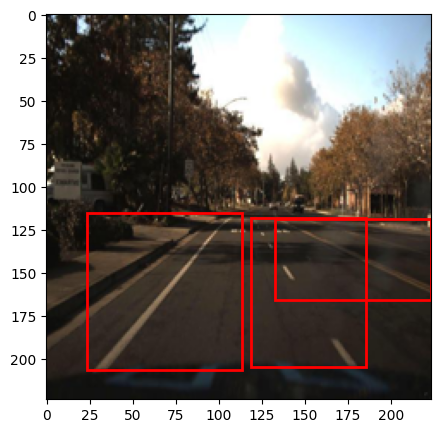

In [ ]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1,2,0)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# Load the entire model
model = torch.load('model.pth')
model.eval()  # Set to evaluation mode if needed

# # Load the state_dict into a model
# model = YourModelClass(*args, **kwargs)  # Initialize your model
# model.load_state_dict(torch.load('model_state.pth'))
# model.eval()


<ipython-input-27-b952b35b64ba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# training for 10 epochs
num_epochs = 1

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # training for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, val_loader, device=device)

  0%|          | 0/1 [00:00<?, ?it/s]/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/18]  eta: 0:25:41  lr: 0.000299  loss: 1.4600 (1.4600)  loss_classifier: 1.2255 (1.2255)  loss_box_reg: 0.0251 (0.0251)  loss_objectness: 0.1940 (0.1940)  loss_rpn_box_reg: 0.0155 (0.0155)  time: 85.6513  data: 0.3995
Epoch: [0]  [10/18]  eta: 0:09:56  lr: 0.003237  loss: 0.6129 (0.8063)  loss_classifier: 0.3719 (0.5841)  loss_box_reg: 0.0781 (0.1047)  loss_objectness: 0.1017 (0.1037)  loss_rpn_box_reg: 0.0151 (0.0138)  time: 74.5182  data: 0.0498


100%|██████████| 1/1 [22:06<00:00, 1326.28s/it]

Epoch: [0]  [17/18]  eta: 0:01:13  lr: 0.005000  loss: 0.4373 (0.6375)  loss_classifier: 0.2199 (0.4211)  loss_box_reg: 0.1328 (0.1242)  loss_objectness: 0.0575 (0.0802)  loss_rpn_box_reg: 0.0122 (0.0120)  time: 73.6765  data: 0.0383
Epoch: [0] Total time: 0:22:06 (73.6814 s / it)


In [ ]:
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')

# Number of epochs
num_epochs = 1

# num_optim = 373  # Number of optimization steps
num_optim = 15

# Loop through epochs
for epoch in range(num_epochs):
    # Initialize the tqdm progress bar for optimization steps
    pbar = tqdm(range(num_optim), desc=f"Epoch {epoch+1}", position=0)

    train_losses = []
    val_losses = []
    optim_steps = 0
    val_iter = iter(val_loader)
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Check if we've completed the specified number of optimization steps
        if optim_steps >= num_optim:
            break

        # Move images and targets to the device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass, loss computation, backward pass, and optimization step
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the progress bar after each optimization step
        pbar.set_postfix(loss=losses.item())
        train_losses.append(losses.item())

        if optim_steps % 5 == 0:
            images, target = next(val_iter)
            val_loss_dict = model(images, target)
            val_loss = sum(loss for loss in val_loss_dict.values())
            val_losses.append(val_loss.item())

        pbar.update(1)  # Increment the progress bar by 1 step

        optim_steps += 1  # Track the number of optimization steps

        # Update the learning rate after each epoch
        lr_scheduler.step()

    # Optional: evaluate after each epoch
    # evaluate(model, val_loader, device=device)

# Save the entire model
torch.save(model, 'model.pth')

# Copy file to Google Drive
# shutil.copy('/content/model.pth', '/content/drive/MyDrive/model.pth')

# # Save only the model's state_dict (recommended)
# torch.save(model.state_dict(), 'model_state.pth')


Epoch 1: 100%|██████████| 15/15 [21:21<00:00, 79.22s/it, loss=0.497]

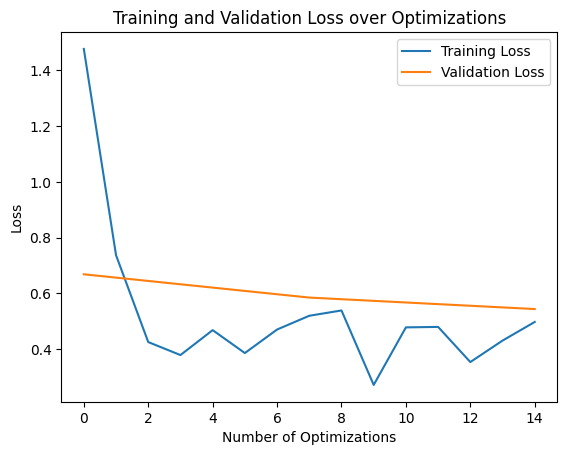

In [ ]:
def to_numpy(data):
    if isinstance(data, list):
        # Convert each item in the list
        return np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data])
    elif isinstance(data, torch.Tensor):
        # Detach and convert single tensor
        return data.detach().cpu().numpy()
    return np.array(data)  # Convert to NumPy array if it's something else

val_losses = to_numpy(val_losses)
train_len = len(train_losses)
val_len = len(val_losses)
x_val = np.linspace(0, train_len - 1, val_len)  # Original x-points for val_losses
val_losses_interp = np.interp(range(train_len), x_val, val_losses)

plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(train_losses)), val_losses_interp, label="Validation Loss")  # Uncomment this line if needed
plt.xlabel("Number of Optimizations")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Optimizations")
plt.legend()
plt.show()


In [ ]:
# Save the entire model
torch.save(model, 'model.pth')

# # Save only the model's state_dict (recommended)
# torch.save(model.state_dict(), 'model_state.pth')

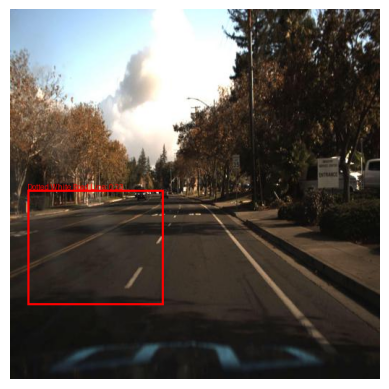

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

labels = {
    1: 'Solid White Road Line',
    2: 'Dotted White Road Line',
    3: 'Double Solid Yellow Road Line'
}

# Define a transform to normalize the image
transform = transforms.Compose([
    transforms.ToTensor()
])

def detect_objects(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        prediction = model(image_tensor)
    return prediction, image

def draw_boxes(image, prediction, score_threshold=0.2):
    draw = ImageDraw.Draw(image)
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label = int(prediction[0]['labels'][element].cpu().numpy())

        if score > score_threshold:
            draw.rectangle(box, outline="red", width=3)
            label_text = labels.get(label, "Unknown")
            label_position = (box[0], box[1] - 10)
            draw.text(label_position, f"{label_text}: {score:.2f}", fill="red")
    return image

image_path = '/content/data/export/1478019954685370994_jpg.rf.049fda8ca86adf1e404b41955eb4aba8.jpg'
prediction, image = detect_objects(image_path)
image_with_boxes = draw_boxes(image, prediction)

plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()


**Technique #2: Canny and Hough**

In [ ]:
import cv2

In [ ]:
# Load the image
image = cv2.imread('/content/data/export/1478019954685370994_jpg.rf.049fda8ca86adf1e404b41955eb4aba8.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

In [ ]:
# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=10, threshold2=80)

In [ ]:
# Define the region of interest (ROI) polygon
height, width = edges.shape
mask = np.zeros_like(edges)

# Define the vertices of the polygon (a trapezoid shape)
polygon = np.array([[
    (0, height),
    (width / 2, height / 2),
    (width, height)
]], np.int32)

# Fill the polygon area with white color (ROI)
cv2.fillPoly(mask, polygon, 255)

# Apply the mask to the edges
masked_edges = cv2.bitwise_and(edges, mask)


In [ ]:
# Apply Hough Transform to detect lines in the edge image
lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=200)

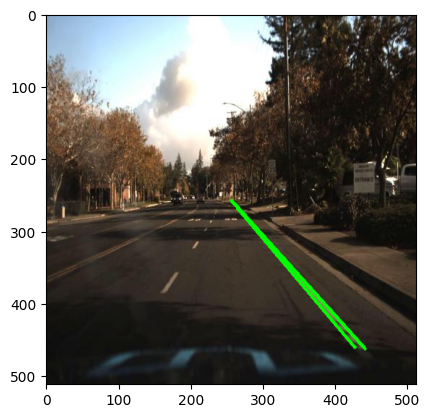

In [ ]:
# Draw the detected lines on the original image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Display the final image with lane markings
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


**Technique #3: Canny to label lanes; ML to detect them**


In [ ]:
!unzip canny_json.zip -d /content/canny_json

Streaming output truncated to the last 5000 lines.
  inflating: /content/canny_json/content/canny_json/1478896526749456792_jpg.rf.adff59451ca287ebcfeb027bc5d1c9ce.json  
  inflating: /content/canny_json/content/canny_json/1478897034053610003_jpg.rf.17N0lnROy9OcyVglOhUm.json  
  inflating: /content/canny_json/content/canny_json/1478021911082870895_jpg.rf.s4XrtD53JhhutSSr3p0R.json  
  inflating: /content/canny_json/content/canny_json/1478899633993703282_jpg.rf.6a5469360f0ba8328c2edde0717b5545.json  
  inflating: /content/canny_json/content/canny_json/1478899436898513600_jpg.rf.816d7b1bcfe5d261106ec44edb706d53.json  
  inflating: /content/canny_json/content/canny_json/1478900605186731957_jpg.rf.2N7bWUYFkuSYARKfilTf.json  
  inflating: /content/canny_json/content/canny_json/1478900564624374533_jpg.rf.4onq4umAFBreJfP5FaJv.json  
  inflating: /content/canny_json/content/canny_json/1478899656274065854_jpg.rf.DPl10GJvJ8OwiKPntZAK.json  
  inflating: /content/canny_json/content/canny_json/14789

In [ ]:
import cv2
import numpy as np
import os
import json
import time

def process_images(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all images in the input folder
    file_list = os.listdir(input_folder)

    # Initialize tqdm progress bar once, and iterate over the files
    for filename in tqdm(file_list, desc="Processing images"):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other extensions if needed
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            # Step 1: Canny edge detection
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 200, 250)

            # Define the region of interest (ROI) polygon
            height, width = edges.shape
            mask = np.zeros_like(edges)

            # Define the vertices of the polygon (a trapezoid shape)
            polygon = np.array([[
                (0, height),
                (width / 2, height / 2),
                (width, height)
            ]], np.int32)

            # Fill the polygon area with white color (ROI)
            cv2.fillPoly(mask, polygon, 255)

            # Apply the mask to the edges
            masked_edges = cv2.bitwise_and(edges, mask)

            # Step 2: Hough Transform for line detection
            lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

            # Step 3: Find bounding box from detected lines
            if lines is not None:
                min_x, min_y, max_x, max_y = float('inf'), float('inf'), float('-inf'), float('-inf')
                annotations = []
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    min_x = min(min_x, x1, x2)
                    max_x = max(max_x, x1, x2)
                    min_y = min(min_y, y1, y2)
                    max_y = max(max_y, y1, y2)

                    # Prepare the annotation data
                    annotation = {
                        "label": 0,
                        "points": {
                            "x_min": int(min_x),
                            "y_min": int(min_y),
                            "x_max": int(max_x),
                            "y_max": int(max_y)
                        }
                    }
                    annotations.append(annotation)

        # Step 4: Create a JSON file for the current image
        json_filename = f"{os.path.splitext(filename)[0]}.json"
        json_path = os.path.join(output_folder, json_filename)

        with open(json_path, 'w') as json_file:
            # Create a dictionary to store the annotations for the image
            data = {"annotations": annotations}
            json.dump(data, json_file, indent=4)

# Example usage
input_folder = "/content/data/export"
output_folder = "/content/canny_json"
process_images(input_folder, output_folder)


Processing images: 100%|██████████| 29801/29801 [03:06<00:00, 160.09it/s]


In [ ]:
class LaneImageDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, width, height, train=True, transforms=None):
        """
        Args:
            images_dir (str): Path to the directory containing images.
            annotations_dir (str): Path to the directory containing JSON annotation files.
            width (int): Target image width.
            height (int): Target image height.
            train (bool): If True, load the training split (80%), else load the test split (20%).
            transforms (callable, optional): Optional transforms to be applied on an image and its targets.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.width = width
        self.height = height
        self.train = train
        self.transforms = transforms

        # Sort and split the dataset into training and test sets
        all_imgs = sorted([img for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])
        train_imgs, test_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)
        self.imgs = train_imgs if train else test_imgs

        # Fix bounding boxes and ensure validity
        self.fixed_imgs = []
        for img_name in self.imgs:
            annotation_path = os.path.join(self.annotations_dir, f"{os.path.splitext(img_name)[0]}.json")
            with open(annotation_path) as f:
                annotations = json.load(f).get('annotations', [])

                valid_boxes = []
                for item in annotations:
                    x_min = item['points']['x_min']
                    y_min = item['points']['y_min']
                    x_max = item['points']['x_max']
                    y_max = item['points']['y_max']

                    # Add padding to zero-width/height boxes
                    if x_min == x_max:
                        x_max += 1.0  # Add padding to width
                    if y_min == y_max:
                        y_max += 1.0  # Add padding to height

                    # Ensure the box is still valid
                    if x_min < x_max and y_min < y_max:
                        item['points'] = {'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max}
                        valid_boxes.append(item)

            if valid_boxes:
                self.fixed_imgs.append(img_name)
                # Optionally save fixed annotations back to file
                with open(annotation_path, 'w') as f:
                    json.dump({'annotations': valid_boxes}, f)

        self.imgs = self.fixed_imgs

    def __getitem__(self, idx):
        # Get image name and paths
        img_name = self.imgs[idx]
        img_path = os.path.join(self.images_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, f"{os.path.splitext(img_name)[0]}.json")

        # Load image
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize((self.width, self.height))
        img_tensor = transforms.ToTensor()(img_resized)

        # Load annotation
        with open(annotation_path) as f:
            annotations = json.load(f)['annotations']

        boxes = []
        labels = []
        img_width, img_height = img.size  # Original image dimensions

        for item in annotations:
            labels.append(item['label'])

            # Access points properly from the nested structure
            x_min = item['points']['x_min']
            y_min = item['points']['y_min']
            x_max = item['points']['x_max']
            y_max = item['points']['y_max']

            # Adjust bounding boxes to match resized dimensions
            x_min_corr = (x_min / img_width) * self.width
            x_max_corr = (x_max / img_width) * self.width
            y_min_corr = (y_min / img_height) * self.height
            y_max_corr = (y_max / img_height) * self.height

            boxes.append([x_min_corr, y_min_corr, x_max_corr, y_max_corr])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Compute areas and iscrowd flags
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx])
        }

        # Apply optional transformations
        if self.transforms:
            transformed = self.transforms(image=img_tensor, bboxes=target['boxes'], labels=target['labels'])
            img_tensor = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'])

        return img_tensor, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
train_dataset = LaneImageDataset(images_dir='/content/data/export', annotations_dir='/content/canny_json/content/canny_json', train=True, width=224, height=224)
val_dataset = LaneImageDataset(images_dir='/content/data/export', annotations_dir='/content/canny_json/content/canny_json', train=False, width=224, height=224)
image_tensor, targets = train_dataset[0]  # Get a single example
print(f"Image shape: {image_tensor.shape}")
print(f"Boxes shape: {targets['boxes'].shape}")
print(f"Labels shape: {targets['labels'].shape}")

Image shape: torch.Size([3, 224, 224])
Boxes shape: torch.Size([3, 4])
Labels shape: torch.Size([3])


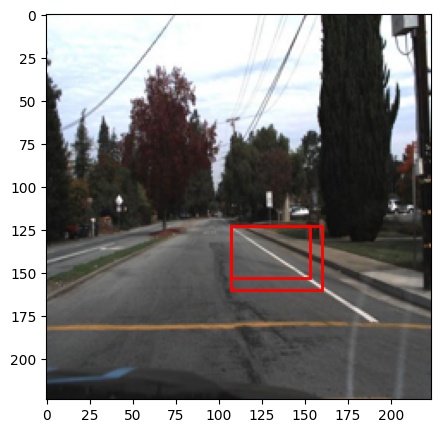

In [ ]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1,2,0)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = train_dataset[20003]
plot_img_bbox(img, target)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 154MB/s]


In [ ]:
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Number of epochs
num_epochs = 1

# num_optim = 373  # Number of optimization steps
num_optim = 30

# Loop through epochs
for epoch in range(num_epochs):
    # Initialize the tqdm progress bar for optimization steps
    pbar = tqdm(range(num_optim), desc=f"Epoch {epoch+1}", position=0)

    train_losses = []
    val_losses = []
    optim_steps = 0
    val_iter = iter(val_loader)
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Check if we've completed the specified number of optimization steps
        if optim_steps >= num_optim:
            break

        # Move images and targets to the device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass, loss computation, backward pass, and optimization step
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the progress bar after each optimization step
        pbar.set_postfix(loss=losses.item())
        train_losses.append(losses.item())

        if optim_steps % 10 == 0:
            images, target = next(val_iter)
            val_loss_dict = model(images, target)
            val_loss = sum(loss for loss in val_loss_dict.values())
            val_losses.append(val_loss)

        pbar.update(1)  # Increment the progress bar by 1 step

        optim_steps += 1  # Track the number of optimization steps

        # Update the learning rate after each epoch
        lr_scheduler.step()

    # Optional: evaluate after each epoch
    # evaluate(model, val_loader, device=device)

# Save the entire model
torch.save(model, 'better_model.pth')

# Copy file to Google Drive
shutil.copy('/content/better_model.pth', '/content/drive/MyDrive/better_model.pth')

with open('/content/drive/My Drive/train_losses.txt', 'w') as file:
    for item in train_losses:
        file.write("%s\n" % item)

with open('/content/drive/My Drive/val_losses.txt', 'w') as file:
    for item in val_losses:
        file.write("%s\n" % item)


# # Save only the model's state_dict (recommended)
# torch.save(model.state_dict(), 'model_state.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1: 100%|██████████| 30/30 [37:56<00:00, 73.70s/it, loss=0.55]

In [ ]:
# Load the entire model
model = torch.load('better_model.pth')
model.eval()  # Set to evaluation mode if needed

# # Load the state_dict into a model
# model = YourModelClass(*args, **kwargs)  # Initialize your model
# model.load_state_dict(torch.load('model_state.pth'))
# model.eval()


<ipython-input-18-037d45d77835>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('better_model.pth')


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

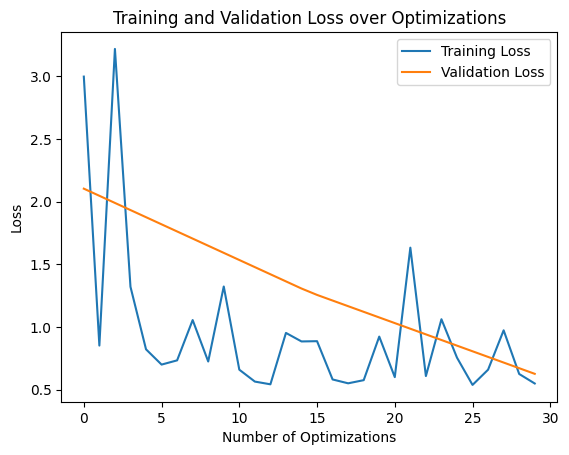

In [ ]:
def to_numpy(data):
    if isinstance(data, list):
        # Convert each item in the list
        return np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data])
    elif isinstance(data, torch.Tensor):
        # Detach and convert single tensor
        return data.detach().cpu().numpy()
    return np.array(data)  # Convert to NumPy array if it's something else

val_losses = to_numpy(val_losses)
train_len = len(train_losses)
val_len = len(val_losses)
x_val = np.linspace(0, train_len - 1, val_len)  # Original x-points for val_losses
val_losses_interp = np.interp(range(train_len), x_val, val_losses)

plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(train_losses)), val_losses_interp, label="Validation Loss")  # Uncomment this line if needed
plt.xlabel("Number of Optimizations")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Optimizations")
plt.legend()
plt.show()


[{'boxes': tensor([[ 94.9805, 433.7453, 129.4585, 469.4579],
        [178.7909, 334.1292, 197.8450, 352.5273],
        [ 98.4614, 429.5066, 209.3029, 449.7998],
        [172.1189, 429.8369, 306.2447, 446.8723],
        [ 72.3097, 436.4763, 145.7955, 462.8787],
        [278.4333, 468.1353, 449.6140, 483.3026],
        [190.2218, 426.4781, 338.7903, 441.7928],
        [282.2974, 482.8498, 473.4644, 496.2159],
        [173.3885, 423.8631, 369.0254, 451.6559],
        [282.9712, 474.7231, 451.7821, 488.0796],
        [119.6061, 357.4577, 149.5863, 367.6308],
        [189.4309, 305.8403, 430.6221, 418.4574],
        [111.6090, 347.1730, 141.5882, 357.8599],
        [169.6831, 354.5266, 353.7802, 408.2240],
        [193.7751, 416.1139, 418.3549, 445.9388],
        [103.5662, 422.8824, 243.8732, 437.3330],
        [119.7143, 349.7748, 147.8761, 360.1857],
        [ 60.6604, 431.7509, 161.0853, 447.8037],
        [ 31.3013, 344.1230, 226.8704, 400.8287],
        [ 24.6577, 435.4405, 162.4652, 

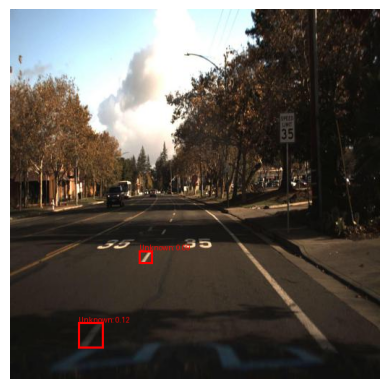

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

labels = {
    0: 'Lane'
}

# Define a transform to normalize the image
transform = transforms.Compose([
    transforms.ToTensor()
])

def detect_objects(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        prediction = model(image_tensor)
    return prediction, image

def draw_boxes(image, prediction, score_threshold=0.08):
    draw = ImageDraw.Draw(image)
    print(prediction)
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label = int(prediction[0]['labels'][element].cpu().numpy())

        if score > score_threshold:
            draw.rectangle(box, outline="red", width=3)
            label_text = labels.get(label, "Unknown")
            label_position = (box[0], box[1] - 10)
            draw.text(label_position, f"{label_text}: {score:.2f}", fill="red")
    return image

image_path = '/content/data/export/1478019956680248165_jpg.rf.ad9d5ee7e46edd991b6c6ff8d3f10644.jpg'
prediction, image = detect_objects(image_path)
image_with_boxes = draw_boxes(image, prediction)

plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()
